In [1]:
import pandas as pd

from gensim.corpora.dictionary import Dictionary

import re
import numpy as np

from nltk.corpus import stopwords
#import nltk
#nltk.download('stopwords')

from razdel import tokenize
import pymorphy2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, \
classification_report, precision_recall_curve, confusion_matrix, \
accuracy_score, recall_score

import itertools
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
news = pd.read_csv('articles.csv')
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv('users_articles.csv')
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [4]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

151

In [5]:
morph = pymorphy2.MorphAnalyzer()

In [6]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [7]:
def clean_text(text):
    
    if not isinstance(text, str):
        text = str(text)
        
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '',text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    return text

In [8]:
def lemmatization(text):
    
    cache = {}
    
    if isinstance(text, str):
        text = str(text)
        
    tokens = tokenize(text)
    words = [_.text for _ in tokens]
    
    words_lem = []
    for w in words:
        if w[0] == '-':
            w = w[1:]
        if len(w) > 1:
            if w in cache:
                words_lem.append(cache[w])
            else:
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru]
    
    return words_lem_without_stopwords

In [9]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 34.5 s


In [10]:
%%time
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 27min 16s


In [11]:
texts = [t for t in news['title'].values]

common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [12]:
%%time
from gensim.models import LdaModel

lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 43.9 s


In [13]:
from gensim.test.utils import datapath

temp_file = datapath('model.lda')
lda.save(temp_file)

lda = LdaModel.load(temp_file)

In [15]:
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(6, 0.14661707),
 (17, 0.15508622),
 (18, 0.41663933),
 (23, 0.21166025),
 (24, 0.05212068)]

In [16]:
num_topics = 25
num_words = 10

x = lda.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

for topic, words in topics_words:
    print('topic_{}: '.format(topic) + ' '.join(words))

topic_0: год военный nn суд обнаружить операция который россия действие российский
topic_1: путин президент россия млрд пресссекретарить владимир пространство превысить российский соглашение
topic_2: остров вирус карта индия япония китайский польский авария приложение кость
topic_3: год это который россия сша млрд компания банк президент также
topic_4: тело мужчина женщина мозг nn место час журнал человек британский
topic_5: врач болезнь фотография кровь страдать больница выяснить лауреат опубликовать гражданство
topic_6: поверхность конкурс супруг определение устойчивый сон орден мозг широко нервный
topic_7: погибнуть страна египет турция произойти турецкий сша пострадать авария катастрофа
topic_8: год компания расчёт производитель километр высота сигнал океан покупка волна
topic_9: это который мочь год человек весь россия свой всё время
topic_10: иран белый терминал понятие вдвое подросток мэрия кинг стихия эммануэль
topic_11: выяснить сотрудник эксперимент полиция смерть чиновник за

In [17]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], 
                               [i[1] for i in lda_tuple]))
    
    output_vector = []
    for i in range(num_topics):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    
    return np.array(output_vector)

In [18]:
topic_matrix = pd.DataFrame([get_lda_vector(text) 
                             for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(num_topics)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id'] + ['topic_{}'.format(i) 
                                          for i in range(num_topics)]]
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.886089,0.0,0.0,0.061841,0.000000,0.000000,...,0.031567,0.000000,0.000000,0.000000,0.000000,0.0,0.012711,0.0,0.000000,0.000000
1,4896,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.201728,0.333153,0.000000,0.000000,0.0,0.240629,0.0,0.000000,0.000000
2,4897,0.0,0.0,0.0,0.000000,0.0,0.0,0.145215,0.000000,0.000000,...,0.000000,0.000000,0.155837,0.416846,0.000000,0.0,0.000000,0.0,0.212107,0.052119
3,4898,0.0,0.0,0.0,0.000000,0.0,0.0,0.109059,0.000000,0.063877,...,0.000000,0.038865,0.049749,0.000000,0.058284,0.0,0.000000,0.0,0.000000,0.000000
4,4899,0.0,0.0,0.0,0.381951,0.0,0.0,0.000000,0.529251,0.000000,...,0.000000,0.000000,0.064319,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [19]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [20]:
users.shape

(8000, 2)

In [21]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, 
    topic_matrix[['topic_{}'.format(i) for i in range(num_topics)]].values))

In [22]:
len(doc_dict)

27000

In [23]:
def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [24]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [25]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [26]:
user_articles_list = users['articles'].iloc[0]
get_user_embedding_mean(user_articles_list)

array([0.11366268, 0.0151211 , 0.        , 0.05130175, 0.0068432 ,
       0.0029718 , 0.01505166, 0.02410981, 0.02756429, 0.28789294,
       0.        , 0.01173808, 0.        , 0.        , 0.        ,
       0.02869901, 0.07490723, 0.00413536, 0.0048059 , 0.17018382,
       0.00553266, 0.06872728, 0.        , 0.02707411, 0.04018608])

In [27]:
user_embeddings_1 = pd.DataFrame([i for i in users['articles'].apply(
    lambda x: get_user_embedding_mean(x), 1)])
user_embeddings_1.columns = ['topic_{}'.format(i) for i in range(num_topics)]
user_embeddings_1['uid'] = users['uid'].values
user_embeddings_1 = user_embeddings_1[['uid'] + ['topic_{}'.format(i) for i in range(num_topics)]]
user_embeddings_1.head(1)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.113663,0.015121,0.0,0.051302,0.006843,0.002972,0.015052,0.02411,0.027564,...,0.028699,0.074907,0.004135,0.004806,0.170184,0.005533,0.068727,0.0,0.027074,0.040186


In [28]:
user_embeddings_2 = pd.DataFrame([i for i in users['articles'].apply(
    lambda x: get_user_embedding_median(x), 1)])
user_embeddings_2.columns = ['topic_{}'.format(i) for i in range(num_topics)]
user_embeddings_2['uid'] = users['uid'].values
user_embeddings_2 = user_embeddings_2[['uid'] + ['topic_{}'.format(i) for i in range(num_topics)]]
user_embeddings_2.head(1)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.129698,0.0,0.0,0.010402,0.0,0.0,0.0,0.020933,0.0,...,0.0,0.013482,0.0,0.0,0.100712,0.0,0.049445,0.0,0.0,0.0


In [29]:
user_embeddings_3 = pd.DataFrame([i for i in users['articles'].apply(
    lambda x: get_user_embedding_max(x), 1)])
user_embeddings_3.columns = ['topic_{}'.format(i) for i in range(num_topics)]
user_embeddings_3['uid'] = users['uid'].values
user_embeddings_3 = user_embeddings_3[['uid'] + ['topic_{}'.format(i) for i in range(num_topics)]]
user_embeddings_3.head(1)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.239995,0.062942,0.0,0.204807,0.030653,0.017831,0.09031,0.053149,0.115344,...,0.086723,0.326518,0.024812,0.028835,0.538644,0.017047,0.182186,0.0,0.162445,0.241117


In [30]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [31]:
user_embeddings_1.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.113663,0.015121,0.000000,0.051302,0.006843,0.002972,0.015052,0.024110,0.027564,...,0.028699,0.074907,0.004135,0.004806,0.170184,0.005533,0.068727,0.0,0.027074,0.040186
1,u108690,0.106637,0.033810,0.003804,0.105784,0.004748,0.002069,0.001930,0.017997,0.005950,...,0.017498,0.006178,0.002308,0.044120,0.082769,0.000000,0.064619,0.0,0.031058,0.011816
2,u108339,0.209833,0.000000,0.000000,0.146682,0.065664,0.004629,0.000000,0.079242,0.010595,...,0.013468,0.008218,0.002627,0.016597,0.037288,0.000000,0.075637,0.0,0.011567,0.000000
3,u101138,0.026560,0.026185,0.000000,0.000000,0.007988,0.000000,0.137774,0.000000,0.060698,...,0.004947,0.007821,0.097944,0.002266,0.170866,0.000000,0.010285,0.0,0.005475,0.000000
4,u108248,0.085812,0.023086,0.000000,0.122140,0.048396,0.009512,0.000000,0.008740,0.006687,...,0.020789,0.005972,0.000000,0.036903,0.137594,0.001703,0.035868,0.0,0.020966,0.004548


In [32]:
X_1 = pd.merge(user_embeddings_1, target, 'left')
X_2 = pd.merge(user_embeddings_2, target, 'left')
X_3 = pd.merge(user_embeddings_3, target, 'left')

In [33]:
data_1 = X_1[['topic_{}'.format(i) for i in range(num_topics)]]
data_2 = X_2[['topic_{}'.format(i) for i in range(num_topics)]]
data_3 = X_3[['topic_{}'.format(i) for i in range(num_topics)]]
target = X_1['churn']

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(data_1, target, random_state=0)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(data_2, target, random_state=0)
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(data_3, target, random_state=0)

In [34]:
logreg_1 = LogisticRegression()
logreg_2 = LogisticRegression()
logreg_3 = LogisticRegression()

logreg_1.fit(X_1_train, y_1_train)
logreg_2.fit(X_2_train, y_2_train)
logreg_3.fit(X_3_train, y_3_train)

LogisticRegression()

In [35]:
preds_1 = logreg_1.predict_proba(X_1_test)[:, 1]
preds_2 = logreg_2.predict_proba(X_2_test)[:, 1]
preds_3 = logreg_3.predict_proba(X_3_test)[:, 1]

In [36]:
logreg_1.predict_proba(X_1_test)[:,1]

array([0.14301283, 0.03982649, 0.36435013, ..., 0.0023405 , 0.03129179,
       0.08012089])

In [37]:
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_1_test, preds_1)
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_2_test, preds_2)
precision_3, recall_3, thresholds_3 = precision_recall_curve(y_3_test, preds_3)

In [39]:
n=-1
fscore_1 = (2 * precision_1[:n] * recall_1[:n]) / (precision_1[:n] + recall_1[:n])
ix_1 = np.argmax(fscore_1)

print('Best Thresholds = %f, F-Score = %.3f, Precision = %.3f, Recall = %.3f' %
     (thresholds_1[ix_1], fscore_1[ix_1], precision_1[ix_1], recall_1[ix_1]))

Best Thresholds = 0.275155, F-Score = 0.736, Precision = 0.711, Recall = 0.763


In [40]:
fscore_2 = (2 * precision_2[:n] * recall_2[:n]) / (precision_2[:n] + recall_2[:n])
ix_2 = np.argmax(fscore_2)


print('Best Thresholds = %f, F-Score = %.3f, Precision = %.3f, Recall = %.3f' %
     (thresholds_2[ix_2], fscore_2[ix_2], precision_2[ix_2], recall_2[ix_2]))

Best Thresholds = 0.312790, F-Score = 0.772, Precision = 0.769, Recall = 0.776


In [41]:
fscore_3 = (2 * precision_3[:n] * recall_3[:n]) / (precision_3[:n] + recall_3[:n])
ix_3 = np.argmax(fscore_3)

print('Best Thresholds = %f, F-Score = %.3f, Precision = %.3f, Recall = %.3f' %
     (thresholds_3[ix_3], fscore_3[ix_3], precision_3[ix_3], recall_3[ix_3]))

Best Thresholds = 0.328424, F-Score = 0.724, Precision = 0.705, Recall = 0.743


In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1679   76]
 [  59  186]]


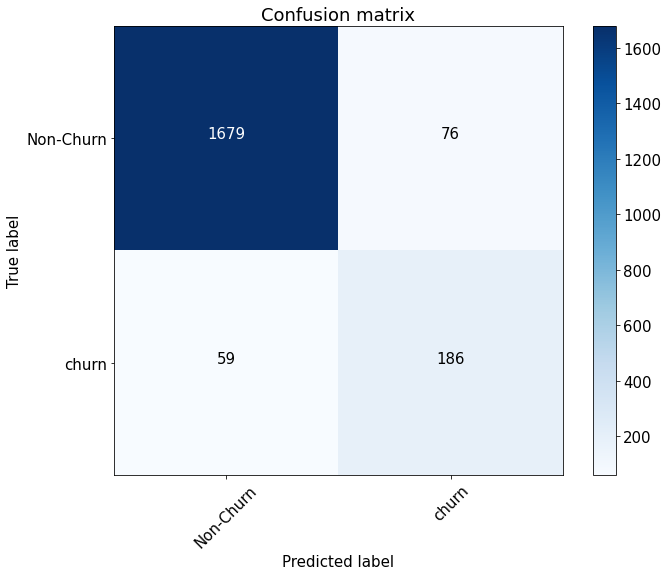

In [43]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_1_test, preds_1>thresholds_1[ix_1])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_1.png")
plt.show()

Confusion matrix, without normalization
[[1698   57]
 [  56  189]]


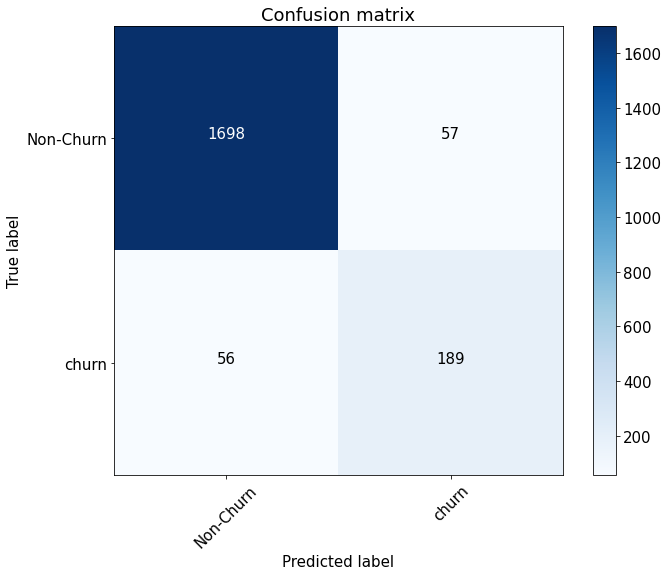

In [44]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_2_test, preds_2>thresholds_2[ix_2])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_2.png")
plt.show()

Confusion matrix, without normalization
[[1679   76]
 [  64  181]]


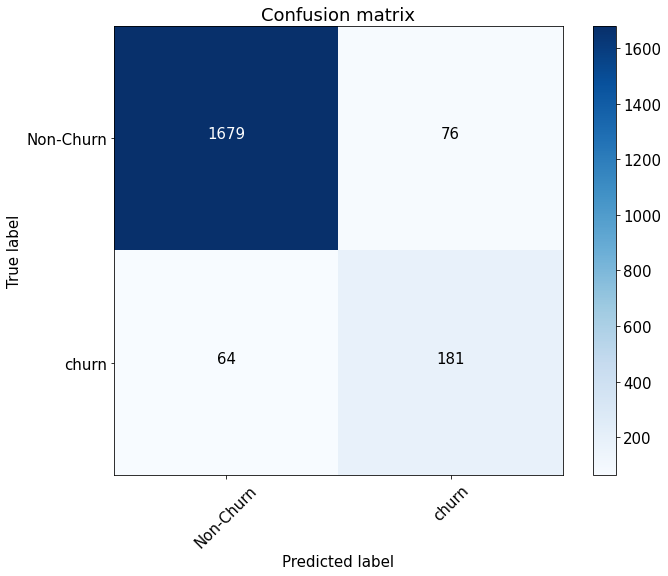

In [45]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_3_test, preds_3>thresholds_3[ix_3])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_3.png")
plt.show()

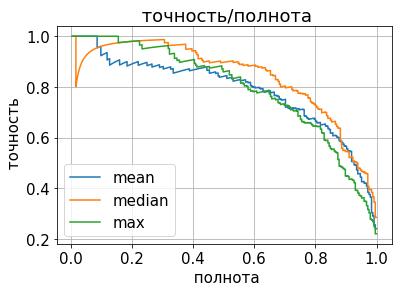

In [46]:
plt.plot(recall_1[:n], precision_1[:n], label='mean')
plt.plot(recall_2[:n], precision_2[:n], label='median')
plt.plot(recall_3[:n], precision_3[:n], label='max')
plt.title(' точность/полнота')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.legend()
plt.grid('On')
plt.show()

In [48]:
print(classification_report(y_1_test, preds_1>thresholds_1[ix_1]))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1755
           1       0.71      0.76      0.73       245

    accuracy                           0.93      2000
   macro avg       0.84      0.86      0.85      2000
weighted avg       0.93      0.93      0.93      2000



In [49]:
print(classification_report(y_2_test, preds_2>thresholds_2[ix_2]))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1755
           1       0.77      0.77      0.77       245

    accuracy                           0.94      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.94      0.94      0.94      2000



In [50]:
print(classification_report(y_3_test, preds_3>thresholds_3[ix_3]))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1755
           1       0.70      0.74      0.72       245

    accuracy                           0.93      2000
   macro avg       0.83      0.85      0.84      2000
weighted avg       0.93      0.93      0.93      2000



In [51]:
(
    roc_auc_score(y_1_test, preds_1),
    roc_auc_score(y_2_test, preds_2),
    roc_auc_score(y_3_test, preds_3)
)

(0.9622931565788708, 0.9706168963311822, 0.954527588813303)